## Model 1 Ontology PCA - Biotechnology & Pharmaceutical Industry<br>
company-year-industry where we get the top metrics categories for the given industry based on company and year relation from GraphDB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.cluster import AgglomerativeClustering


In [2]:
sparql = SPARQLWrapper("http://Vins-Macbook.local:7200/repositories/PCA_Ontology")

In [3]:
# Define the SPARQL query to extract ESG observations.
sparql.setQuery("""
                
PREFIX ex: <http://example.org/esg#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?company ?year ?metric ?value ?category ?pillar ?industry

WHERE {
  ?obs a ex:ESGObservation ;
       ex:hasCompany ?company ;
       ex:hasYear ?year ;
       ex:hasMetric ?metric ;
       ex:hasValue ?value .
  ?metric ex:hasCategory ?category ;
          ex:hasPillar ?pillar; 
          ex:belongsToIndustry ?industry .
   FILTER(regex(str(?industry), "Biotechnology", "i"))
}       

""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [4]:
# Convert SPARQL results to a flat list of records
records = []
for result in results["results"]["bindings"]:
    company = result["company"]["value"].split("#")[-1]  # extract local name
    year = result["year"]["value"]
    metric = result["metric"]["value"].split("#")[-1]    # extract local name
    value = float(result["value"]["value"])
    category = result["category"]["value"].split("#")[-1]
    industry = result["industry"]["value"].split("#")[-1]
    pillar = result["pillar"]["value"].split("#")[-1]    # extract local name for pillar
    records.append({
        "company": company,
        "year": year,
        "metric": metric,
        "value": value,
        "category": category,
        "industry": industry,
        "pillar": pillar  
    })

In [5]:
# Create DataFrame from records
df_raw_bp = pd.DataFrame(records)

# Create a unique identifier for each entity (company_year)
df_raw_bp["entity"] = df_raw_bp["company"] + "_" + df_raw_bp["year"]

# Pivot: rows = entity, columns = metric, values = value
df_pivot_bp = df_raw_bp.pivot_table(index="entity", columns="metric", values="value")
# Replace 0 values with NaN (assuming zeros indicate missing/unreported values)
df_pivot_bp = df_pivot_bp.replace(0, np.nan)

# # Drop columns with more than 90% missing values
# threshold = 0.8
# cols_to_keep = [col for col in df_pivot_bp.columns if df_pivot_bp[col].isnull().mean() <= threshold]
# df_pivot_bp_filtered = df_pivot_bp[cols_to_keep]

# Compute the median for each metric (column), ignoring NaN
median_values = df_pivot_bp.median()

# Impute the missing values with the corresponding column medians
df_pivot_bp_imputed = df_pivot_bp.fillna(median_values)

In [6]:
# Standardization is important for PCA to give each feature equal weight.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot_bp_imputed)

# Perform PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio per PC:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance)) # will tell us how much information each PC is capturing 

Explained Variance Ratio per PC: [0.25608652 0.21766488 0.18496549 0.18054765]
Cumulative Explained Variance: [0.25608652 0.4737514  0.65871689 0.83926453]


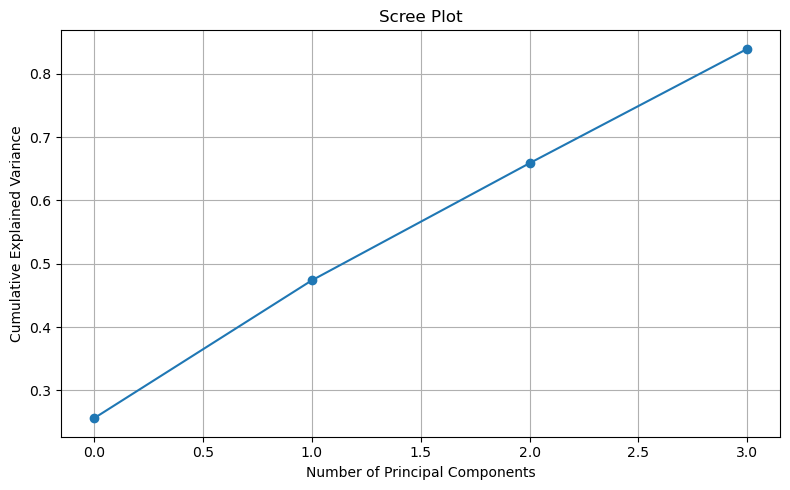

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

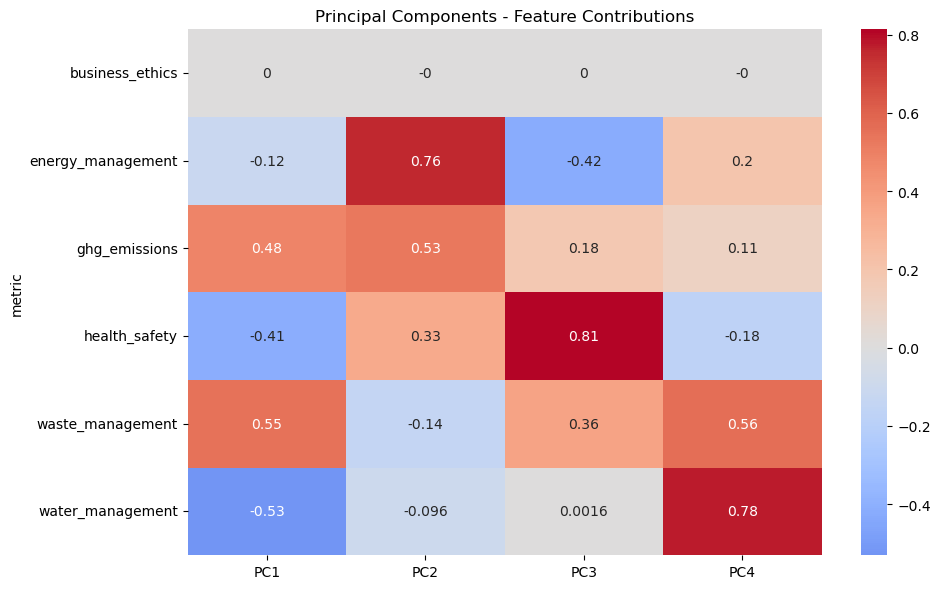

In [8]:
# Loadings indicate how much each original ESG metric contributes to each PC.
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pivot_bp_imputed.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap="coolwarm", center=0)
plt.title("Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()

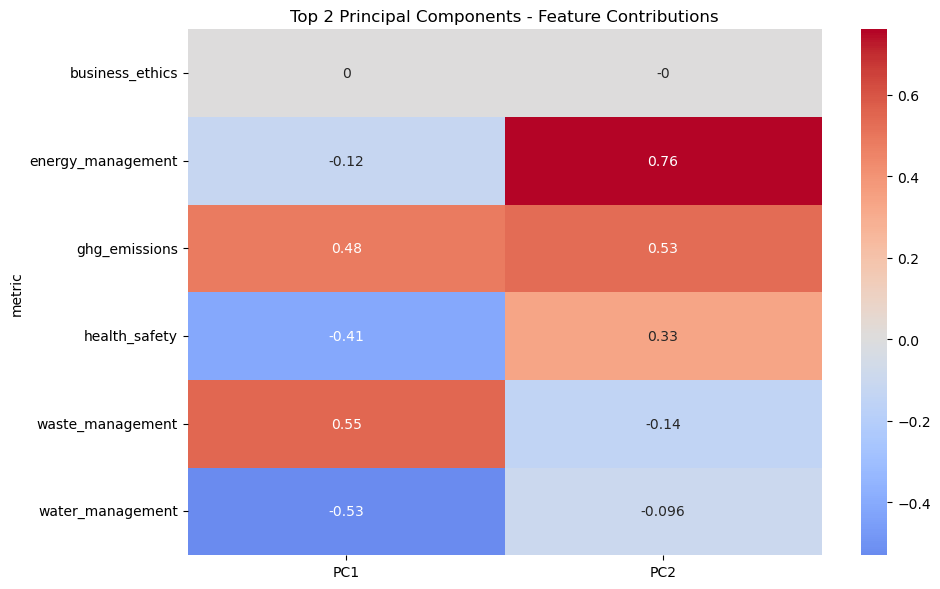

In [9]:
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm", center=0)
plt.title("Top 2 Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()

In [10]:
# These scores are the representation of each observation in the PC space.
pca_scores = pd.DataFrame(
    pca_result,
    columns=[f"PC{i+1}" for i in range(pca_result.shape[1])]
)
pca_scores["entity"] = df_pivot_bp_imputed.index

In [11]:
# Merge loadings with the pillar information

# First, create a dataframe of unique metric→pillar mappings from df_raw.
df_metric_pillar = df_raw_bp[['metric', 'pillar']].drop_duplicates()

# loadings index is the metric name, so we reset that index to merge.
loadings_with_pillar = (
    loadings
    .reset_index()                        # "index" is the metric name
    .rename(columns={'index': 'metric'})  
    .merge(df_metric_pillar, on='metric', how='left')
)

# Look at the top metrics (by absolute loading) for a given PC

# top metrics for PC1 (largest absolute value of loading)
pc1_sorted = loadings_with_pillar[['metric', 'pillar', 'PC1']] \
    .assign(loading_abs=loadings_with_pillar['PC1'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC1:")
print(pc1_sorted.head(10))

# top metrics for PC2
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC2']] \
    .assign(loading_abs=loadings_with_pillar['PC2'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC2:")
print(pc2_sorted.head(10))

# top metrics for PC3
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC3']] \
    .assign(loading_abs=loadings_with_pillar['PC3'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC3:")
print(pc2_sorted.head(10))

# top metrics for PC4
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC4']] \
    .assign(loading_abs=loadings_with_pillar['PC4'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC4:")
print(pc2_sorted.head(10))

Top metrics driving PC1:
              metric         pillar       PC1  loading_abs
4   waste_management         e_risk  0.548426     0.548426
5   waste_management  e_opportunity  0.548426     0.548426
6   water_management         e_risk -0.530422     0.530422
7   water_management  e_opportunity -0.530422     0.530422
2      ghg_emissions         e_risk  0.482788     0.482788
3      health_safety         s_risk -0.413071     0.413071
1  energy_management  e_opportunity -0.119036     0.119036
0    business_ethics         s_risk  0.000000     0.000000
Top metrics driving PC2:
              metric         pillar       PC2  loading_abs
1  energy_management  e_opportunity  0.760447     0.760447
2      ghg_emissions         e_risk  0.529758     0.529758
3      health_safety         s_risk  0.334202     0.334202
4   waste_management         e_risk -0.142188     0.142188
5   waste_management  e_opportunity -0.142188     0.142188
6   water_management         e_risk -0.095751     0.095751
7   wa

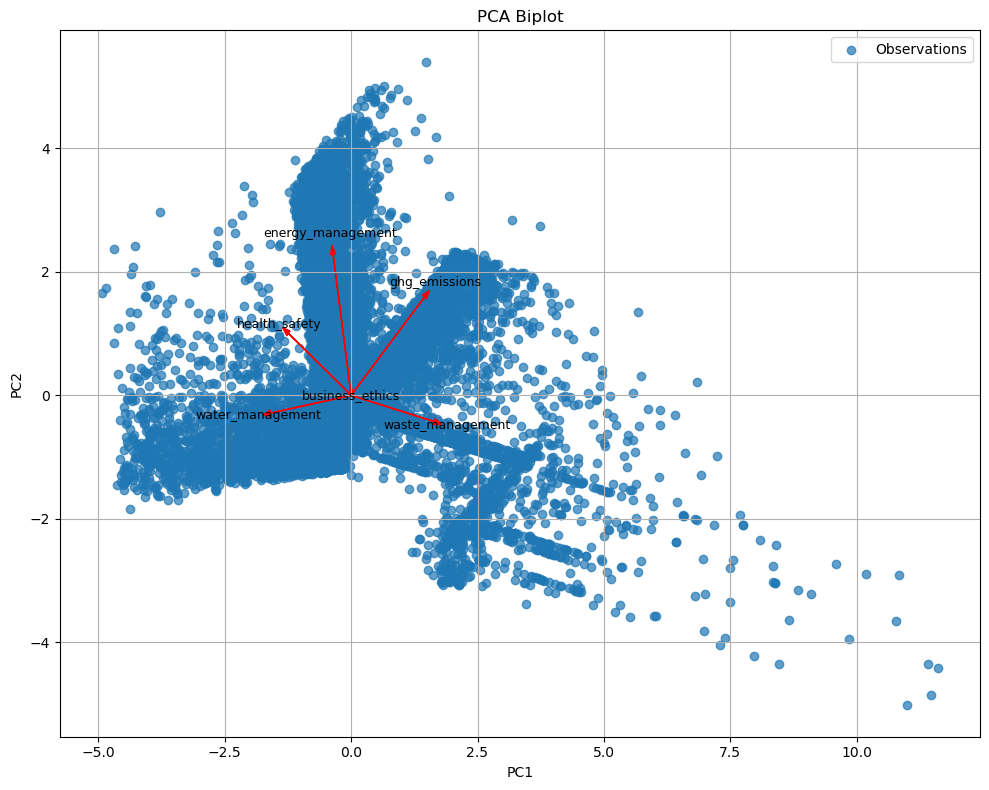

In [12]:
# Create a PCA biplot for PC1 and PC2
plt.figure(figsize=(10, 8))

# Plot the PCA scores (observations)
plt.scatter(pca_scores["PC1"], pca_scores["PC2"], alpha=0.7, label="Observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

# Scale factor for arrows (to make the vectors visible in the score space)
# You might need to adjust this scaling factor depending on your data.
arrow_scale = 3

# Plot the loadings as arrows
for i, metric in enumerate(loadings.index):
    
    # Get the loadings for PC1 and PC2
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    
    # Plot an arrow for each metric
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    
    # Annotate the arrow with the metric name
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

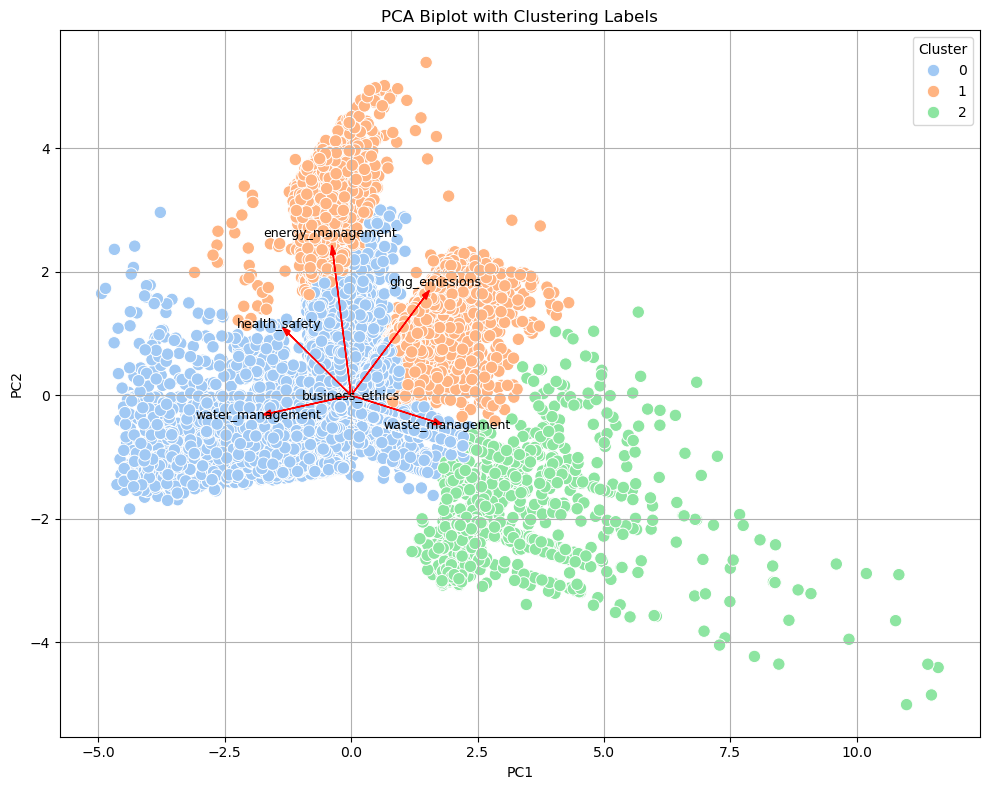

In [13]:
# Use Agglomerative Clustering on the first two principal components
agg_clust = AgglomerativeClustering(n_clusters=3)
clusters = agg_clust.fit_predict(pca_scores[["PC1", "PC2"]])
pca_scores["cluster"] = clusters

# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))

# Plot the observations with cluster colors
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_scores, palette="pastel", s=80)

# Define an arrow scale factor (adjust as needed)
arrow_scale = 3

# Plot the loadings as arrows
for metric in loadings.index:
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.title("PCA Biplot with Clustering Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Identify which columns are the PC loadings
pc_cols = [col for col in loadings_with_pillar.columns if col.startswith("PC")]

# Melt the loadings DataFrame so that each row contains one metric’s loading for a given PC
df_melted = loadings_with_pillar.melt(
    id_vars=["metric", "pillar"],      # Keep these columns fixed
    value_vars=pc_cols,                # Unpivot the PC columns
    var_name="PC",                     # New column indicating which PC
    value_name="loading"               # New column with the loading value
)

# Create a column for the absolute loading for ranking purposes
df_melted["abs_loading"] = df_melted["loading"].abs()

# For each PC, select the top N metrics by absolute loading
top_n = 10
top_metrics = df_melted.groupby("PC", group_keys=False).apply(lambda g: g.nlargest(top_n, "abs_loading")).reset_index(drop=True)

top_metrics = top_metrics[["PC", "metric", "pillar", "abs_loading"]]

print("Top metrics driving each PC:")
print(top_metrics)

Top metrics driving each PC:
     PC             metric         pillar  abs_loading
0   PC1   waste_management         e_risk     0.548426
1   PC1   waste_management  e_opportunity     0.548426
2   PC1   water_management         e_risk     0.530422
3   PC1   water_management  e_opportunity     0.530422
4   PC1      ghg_emissions         e_risk     0.482788
5   PC1      health_safety         s_risk     0.413071
6   PC1  energy_management  e_opportunity     0.119036
7   PC1    business_ethics         s_risk     0.000000
8   PC2  energy_management  e_opportunity     0.760447
9   PC2      ghg_emissions         e_risk     0.529758
10  PC2      health_safety         s_risk     0.334202
11  PC2   waste_management         e_risk     0.142188
12  PC2   waste_management  e_opportunity     0.142188
13  PC2   water_management         e_risk     0.095751
14  PC2   water_management  e_opportunity     0.095751
15  PC2    business_ethics         s_risk     0.000000
16  PC3      health_safety         s

In [15]:
# Sort the results by PC, then by pillar (alphabetically), then by absolute loading (descending)
top_metrics = top_metrics.sort_values(by=["PC", "pillar", "abs_loading"], ascending=[True, True, False])

print("Top metrics driving each PC:")
print(top_metrics)

Top metrics driving each PC:
     PC             metric         pillar  abs_loading
1   PC1   waste_management  e_opportunity     0.548426
3   PC1   water_management  e_opportunity     0.530422
6   PC1  energy_management  e_opportunity     0.119036
0   PC1   waste_management         e_risk     0.548426
2   PC1   water_management         e_risk     0.530422
4   PC1      ghg_emissions         e_risk     0.482788
5   PC1      health_safety         s_risk     0.413071
7   PC1    business_ethics         s_risk     0.000000
8   PC2  energy_management  e_opportunity     0.760447
12  PC2   waste_management  e_opportunity     0.142188
14  PC2   water_management  e_opportunity     0.095751
9   PC2      ghg_emissions         e_risk     0.529758
11  PC2   waste_management         e_risk     0.142188
13  PC2   water_management         e_risk     0.095751
10  PC2      health_safety         s_risk     0.334202
15  PC2    business_ethics         s_risk     0.000000
17  PC3  energy_management  e_opport